In [1]:
%load_ext autoreload
%reload_ext autoreload

In [2]:
# %matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import os
import scipy.io
import neuronumba
import scipy.integrate as integrate
from scipy.linalg import expm
from scipy.linalg import solve_continuous_lyapunov
from typing import Union
#
from DataLoaders.baseDataLoader import DataLoader
import ADNI_A


from functions_FDT_numba_v8 import *

from functions_boxplots_WN3_v0 import *
from functions_boxplots_WN3_v0 import plot_boxes_HC_MCI_AD
import filterps
from functions_violinplots_WN3_v0 import plot_violins_HC_MCI_AD

Base Folder: /Users/mellebolding/MSc/Thesis/ADNI-A/DataLoaders/WorkBrain
Raw Data Folder: /Users/mellebolding/MSc/Thesis/ADNI-A/DataLoaders/WorkBrain/_Data_Raw
Produced Data Folder: /Users/mellebolding/MSc/Thesis/ADNI-A/DataLoaders/WorkBrain/_Data_Produced
0: Subject 003_S_6014 classified as HC
1: Subject 011_S_4547 classified as AD
2: Subject 036_S_4430 classified as AD
3: Subject 002_S_1261 classified as MCI
4: Subject 007_S_4488 classified as HC
5: Subject 003_S_1122 classified as MCI
6: Subject 036_S_4715 classified as AD
7: Subject 023_S_1190 classified as AD
8: Subject 168_S_6142 classified as AD
9: Subject 012_S_6073 classified as MCI
10: Subject 002_S_0413 classified as HC
11: Subject 002_S_4229 classified as MCI
12: Subject 007_S_4387 classified as HC
13: Subject 023_S_4115 classified as MCI
14: Subject 002_S_1280 classified as HC
15: Subject 002_S_4799 classified as HC
16: Subject 002_S_5230 classified as SMC
17: Subject 114_S_6039 classified as AD
18: Subject 002_S_6103 clas

In [13]:
DL = ADNI_A.ADNI_A()

# Loading the data for all subjects
HC_IDs = DL.get_groupSubjects('HC')
HC_MRI = {}
for subject in HC_IDs:
    data = DL.get_subjectData(subject)
    HC_MRI[subject] = data[subject]['timeseries'].transpose()

MCI_IDs = DL.get_groupSubjects('MCI')
MCI_MRI = {}
for subject in MCI_IDs:
    data = DL.get_subjectData(subject)
    MCI_MRI[subject] = data[subject]['timeseries'].transpose()

AD_IDs = DL.get_groupSubjects('AD')
AD_MRI = {}
for subject in AD_IDs:
    data = DL.get_subjectData(subject)
    AD_MRI[subject] = data[subject]['timeseries'].transpose()

# Okay this is loading in the effecetive connectivity, so we cannot use this for f_diff
# we need to use the data loader to get the timeseries data
EC_HC_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/HC_FDT_results_filters0109.mat')
EC_MCI_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/MCI_FDT_results_filters0109.mat')
EC_AD_data = scipy.io.loadmat('ADNI-A_DATA/EC_filterted/AD_FDT_results_filters0109.mat')
#print(EC_HC_data.keys()) # check the keys

#print(EC_MCI_data['Ceff_subjects'])
print(len(EC_HC_data['Ceff_subjects'])) # check the number of subjects
print(len(EC_MCI_data['Ceff_subjects'])) # check the number of subjects
print(len(EC_AD_data['Ceff_subjects'])) # check the number of subjects
NPARCELLS = len(EC_AD_data['Ceff_subjects'][0])



cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
cutting lengthy timeseries: 976 to 197
17
9
10


In [14]:
def calc_H_freq(
        all_HC_fMRI: Union[np.ndarray, dict], 
        tr: float, 
        version: filterps.FiltPowSpetraVersion=filterps.FiltPowSpetraVersion.v2021
    ):
        """
        Compute H freq for each node. 
        
        Parameters
        ----------
        all_HC_fMRI: The fMRI of the "health control" group. Can be given in a dictionaray format, 
                     or in an array format (subject, time, node).
                     NOTE: that the signals must already be filitered. 
        tr: TR in milliseconds
        version: Version of FiltPowSpectra to use

        Returns
        -------
        The h frequencies for each node
        """
        f_diff = filterps.filt_pow_spetra_multiple_subjects(all_HC_fMRI, tr, version)
        return 2 * np.pi * f_diff  # omega

In [22]:
I_FDT_sub_par = np.zeros([3,36,379])
I_FDT_sub = np.zeros([3,36])
I_FDT_par = np.zeros([3,379])


RSN = 1
if RSN == 1:
    Default = [25, 27, 29, 30, 32, 33, 34, 60, 63, 64, 65, 67, 68, 70, 71, 73, 74, 75, 86, 87, 93, 122, 127, 128, 129, 130, 131, 148, 149, 150, 160, 175, 176, 177, 205, 209, 210, 212, 213, 214, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 254, 255, 256, 266, 268, 273, 277, 286, 291, 298, 299, 302, 304, 305, 306, 307, 308, 309, 311, 313, 318, 321, 328, 329, 330, 334, 340, 341, 344, 349, 355, 356, 359]
    DorsAttn = [9, 16, 26, 28, 41, 44, 45, 46, 47, 48, 49, 51, 53, 79, 95, 115, 116, 135, 136, 137, 139, 140, 144, 189, 190, 196, 197, 224, 225, 226, 227, 228, 229, 231, 259, 275, 276, 295, 296, 315, 316, 317, 319, 320, 324, 325, 336]
    SalVentAttn = [10, 11, 24, 31, 36, 37, 43, 58, 59, 77, 85, 107, 108, 109, 111, 112, 113, 138, 146, 147, 166, 168, 204, 206, 211, 216, 217, 222, 223, 236, 238, 239, 257, 278, 285, 287, 288, 289, 292, 293, 294, 326, 327, 346, 348, 357, 358]
    Cont = [13, 14, 57, 61, 62, 66, 69, 72, 76, 78, 80, 81, 82, 83, 84, 90, 94, 96, 97, 110, 132, 143, 161, 169, 170, 178, 179, 193, 194, 208, 237, 252, 253, 258, 260, 261, 262, 263, 264, 265, 270, 274, 290, 312, 323, 350]
    SomMot = [7, 8, 23, 35, 38, 39, 40, 42, 50, 52, 54, 55, 56, 98, 99, 100, 101, 102, 103, 104, 105, 106, 114, 123, 124, 167, 172, 173, 174, 187, 188, 191, 203, 207, 215, 218, 219, 220, 221, 230, 232, 233, 234, 235, 279, 280, 281, 282, 283, 284, 303, 347, 352, 353, 354]
    Limbic = [88, 89, 91, 92, 117, 121, 133, 134, 163, 164, 165, 171, 267, 269, 271, 272, 297, 301, 310, 314, 343, 345, 351]
    Vis = [0, 1, 2, 3, 4, 5, 6, 12, 15, 17, 18, 19, 20, 21, 22, 118, 119, 120, 125, 126, 141, 142, 145, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 180, 181, 182, 183, 184, 185, 186, 192, 195, 198, 199, 200, 201, 202, 300, 322, 331, 332, 333, 335, 337, 338, 339, 342]

    I_FDT_sub_par_def = np.zeros([3,36,len(Default)])
    I_FDT_sub_def = np.zeros([3,36])
    I_FDT_par_def = np.zeros([3,len(Default)])
    I_FDT_sub_par_dors = np.zeros([3,36,len(DorsAttn)])
    I_FDT_sub_dors = np.zeros([3,36])
    I_FDT_par_dors = np.zeros([3,len(DorsAttn)])
    I_FDT_sub_par_sal = np.zeros([3,36,len(SalVentAttn)])
    I_FDT_sub_sal = np.zeros([3,36])
    I_FDT_par_sal = np.zeros([3,len(SalVentAttn)])
    I_FDT_sub_par_cont = np.zeros([3,36,len(Cont)])
    I_FDT_sub_cont = np.zeros([3,36])
    I_FDT_par_cont = np.zeros([3,len(Cont)])
    I_FDT_sub_par_som = np.zeros([3,36,len(SomMot)])
    I_FDT_sub_som = np.zeros([3,36])
    I_FDT_par_som = np.zeros([3,len(SomMot)])
    I_FDT_sub_par_limb = np.zeros([3,36,len(Limbic)])
    I_FDT_sub_limb = np.zeros([3,36])
    I_FDT_par_limb = np.zeros([3,len(Limbic)])
    I_FDT_sub_par_vis = np.zeros([3,36,len(Vis)])
    I_FDT_sub_vis = np.zeros([3,36])
    I_FDT_par_vis = np.zeros([3,len(Vis)])

### Set condition
# COND = 1
cond_index_map = {'HC': 0, 'MCI': 1, 'AD': 2}
group_names = ['HC', 'MCI', 'AD']
group_sizes = {'HC': 17, 'MCI': 9, 'AD': 10}
Ceff_data_map = {
    'HC': EC_HC_data['Ceff_subjects'],
    'MCI': EC_MCI_data['Ceff_subjects'],
    'AD': EC_AD_data['Ceff_subjects']
}
MRI_map = {
    'HC': HC_MRI,
    'MCI': MCI_MRI,
    'AD': AD_MRI
}
for cond in group_names:
    cond_index = cond_index_map[cond]
    n_subs = group_sizes[cond]
    for sub_index in range(n_subs):
        SUB = sub_index  # zero-indexed or add +1 if needed

        # Get Ceff data and f_diff
        Ceffgroup = Ceff_data_map[cond]
        f_diff = calc_H_freq(MRI_map[cond], 3000, filterps.FiltPowSpetraVersion.v2021)
        sigma = 0.08

        Connectivity = Ceffgroup[sub_index,:,:]
        norm = np.max(Connectivity)
        Ceff = Connectivity[:NPARCELLS,:NPARCELLS]
        
        filename = f"Connectivity_Ceff_COND_{cond}_SUB_{SUB}.png"
        plt.imshow(Ceff)
        plt.colorbar()
        #plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()

        ### We define the variables for the HOPF MODEL ########################
        ## Bifurcation parameter (same for all parcells) [Hopf only]
        aparam = -0.02
        avec = aparam * np.ones(NPARCELLS) # Possibility for different a values

        ## Nodes frequencies [Hopf only]
        omega = f_diff[:NPARCELLS]
        
        ## Coupling constant [Hopf only]
        gconst = 1.0

        ## Repetition time [Hopf only]
        TR = 2

        ### Set noise standard deviation ######################################
        sigma = sigma * np.ones(NPARCELLS)

        ### Select Model: #####################################################
        ## LINHOPF == 1 --> Linear Hopf
        ## LINHOPF == 0 --> Langevin Langevin
        LINHOPF = 1

        ## Linear Hopf
        if LINHOPF == 1:
            Gamma = -construct_matrix_A(avec, omega, Ceff, gconst)
            Ndim = 2 * NPARCELLS
            sigma = np.append(sigma, sigma)

        ### Initial conditions: ###############################################
        ## Random initial condition (v0 = v0bias + v0std*np.random.standard_normal)
        v0std = sigma
        v0bias = 0.0

        ### Check if the system is stable, i.e. Re(eigenvalues_of_Gamma)>0 ####
        eigenvalues_of_Gamma = np.linalg.eigvals(Gamma)
        is_stable = np.all(np.real(eigenvalues_of_Gamma) > 0)
        # tol = 1e-12
        # is_stable = np.all(np.real(eigenvalues_of_Gamma) > tol)
        if is_stable == False:
            print('System unstable! For CONDITION', cond, 'SUB', SUB)
            break
        #######################################################################

        ### Simulate and plot #################################################
        t0 = 0
        tfinal = 200
        dt = 0.01
        times = np.arange(t0, tfinal+dt, dt)

        v0 = v0std * np.random.standard_normal(Ndim) + v0bias
        vsim, noise = Integrate_Langevin_ND_Optimized(Gamma, sigma, initcond=v0, duration=tfinal, integstep=dt)

        NPARCELLS_plot = NPARCELLS
        if NPARCELLS > 5:
            NPARCELLS_plot = 5

        plt.figure(figsize=(13,5))
        plt.plot(times, noise[0,:], lw=0.5, color='gray', alpha=0.5)
        for i in range(NPARCELLS_plot):
            index = i + 1
            plt.plot(times, vsim[i,:], label=r'$x_{sim}[%d]$'%index)
        plt.xlim(0,tfinal)
        plt.ylabel(r'$x_{sim}(t)$ (a.u.)', fontsize=12)
        plt.xlabel('Time (a.u.)', fontsize=12)
        plt.legend()

        # Plot a simulation for each subject in each condition
        if LINHOPF == 1:
            filename = f"Simulation_LinHopf_COND_{cond}_SUB_{SUB}.png"
        if LINHOPF == 0:
            filename = f"Simulation_LinLang_COND_{cond}_SUB_{SUB}.png"
        #plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()
        #######################################################################


        ndim = np.shape(Gamma)[0]
        V_0 = V_0_calculation_v0gauss(v0std, v0bias, ndim)


        plt.imshow(V_0)
        plt.colorbar()
        #plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()
        #######################################################################

        ### Define the timeframe for the calculation ##########################
        # Define the temporal resolution for the calculations
        t0 = 0
        tmax = 100

        ### Integral Violation of FDT: I ######################################
        ###
        ### Calculation and plot of I(t=tmax,s=0) for each node
        ts = 0
        I_tmax_s0 = Its_Langevin_ND(Gamma, sigma, V_0, tmax, ts)[0:NPARCELLS]
        plt.plot(np.arange(NPARCELLS)+1, I_tmax_s0,'.-',color='gray',alpha=0.7)
        plt.gca().set_prop_cycle(None)
        for par in range(NPARCELLS):
            plt.plot(par+1,I_tmax_s0[par],'o-')

        plt.title(r'FDT: $M_I=I(t=t_{max},s=0)$')
        plt.xlabel('Node')
        plt.ylabel(r'FDT: $M_I$')
        x_ticks = 10 if NPARCELLS > 20 else 1
        plt.xticks(np.arange(0, NPARCELLS+1, x_ticks))

        filename = f"FDT_I_Nodes_COND_{cond}_SUB_{SUB}.png"
        plt.savefig(filename, format='png', dpi=300)  # Save the figure
        plt.close()

        I_FDT_sub_par[cond_index, sub_index, :] = I_tmax_s0
        if RSN == 1:
            I_FDT_sub_par_def[cond_index, sub_index, :] = I_tmax_s0[Default]
            I_FDT_sub_par_dors[cond_index, sub_index, :] = I_tmax_s0[DorsAttn]
            I_FDT_sub_par_sal[cond_index, sub_index, :] = I_tmax_s0[SalVentAttn]
            I_FDT_sub_par_cont[cond_index, sub_index, :] = I_tmax_s0[Cont]
            I_FDT_sub_par_som[cond_index, sub_index, :] = I_tmax_s0[SomMot]
            I_FDT_sub_par_limb[cond_index, sub_index, :] = I_tmax_s0[Limbic]
            I_FDT_sub_par_vis[cond_index, sub_index, :] = I_tmax_s0[Vis]



I_FDT_sub = np.mean(I_FDT_sub_par, axis=2)
I_FDT_par = np.mean(I_FDT_sub_par, axis=1)
if RSN == 1:
    I_FDT_sub_def = np.mean(I_FDT_sub_par_def, axis=2)
    I_FDT_par_def = np.mean(I_FDT_sub_par_def, axis=1)
    I_FDT_sub_dors = np.mean(I_FDT_sub_par_dors, axis=2)
    I_FDT_par_dors = np.mean(I_FDT_sub_par_dors, axis=1)
    I_FDT_sub_sal = np.mean(I_FDT_sub_par_sal, axis=2)
    I_FDT_par_sal = np.mean(I_FDT_sub_par_sal, axis=1)
    I_FDT_sub_cont = np.mean(I_FDT_sub_par_cont, axis=2)
    I_FDT_par_cont = np.mean(I_FDT_sub_par_cont, axis=1)
    I_FDT_sub_som = np.mean(I_FDT_sub_par_som, axis=2)
    I_FDT_par_som = np.mean(I_FDT_sub_par_som, axis=1)
    I_FDT_sub_limb = np.mean(I_FDT_sub_par_limb, axis=2)
    I_FDT_par_limb = np.mean(I_FDT_sub_par_limb, axis=1)
    I_FDT_sub_vis = np.mean(I_FDT_sub_par_vis, axis=2)
    I_FDT_par_vis = np.mean(I_FDT_sub_par_vis, axis=1)
    


/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


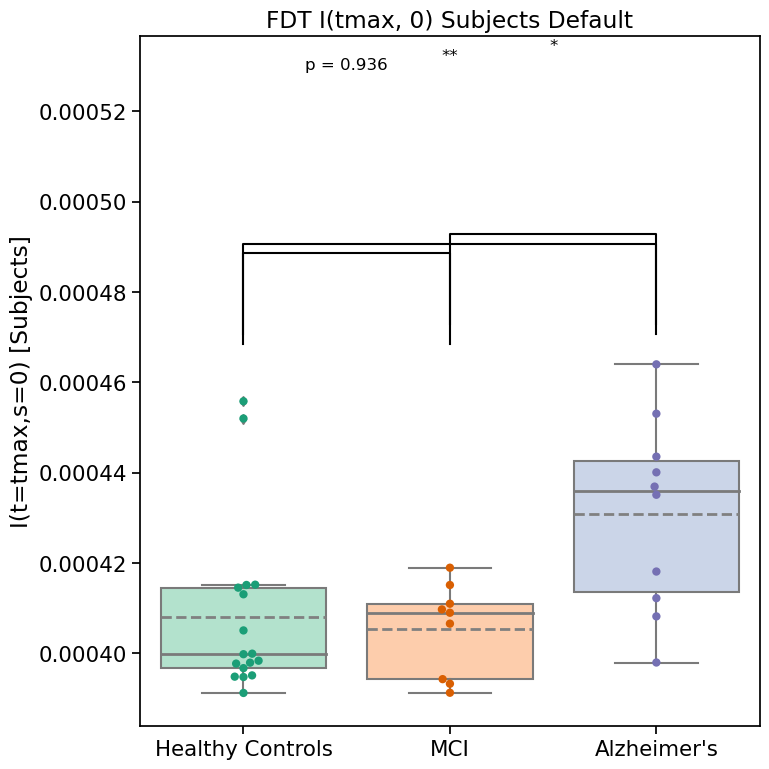

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


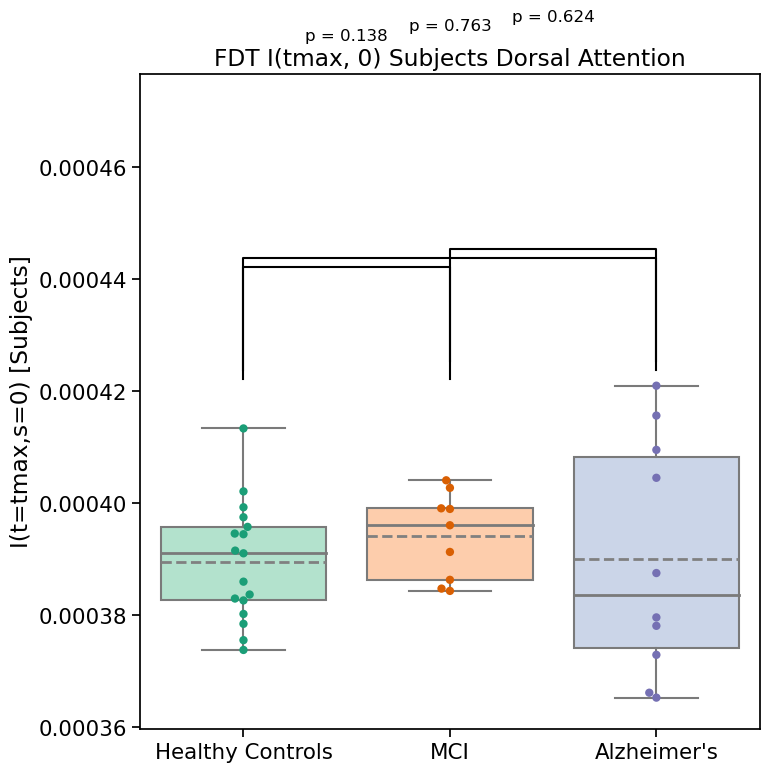

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


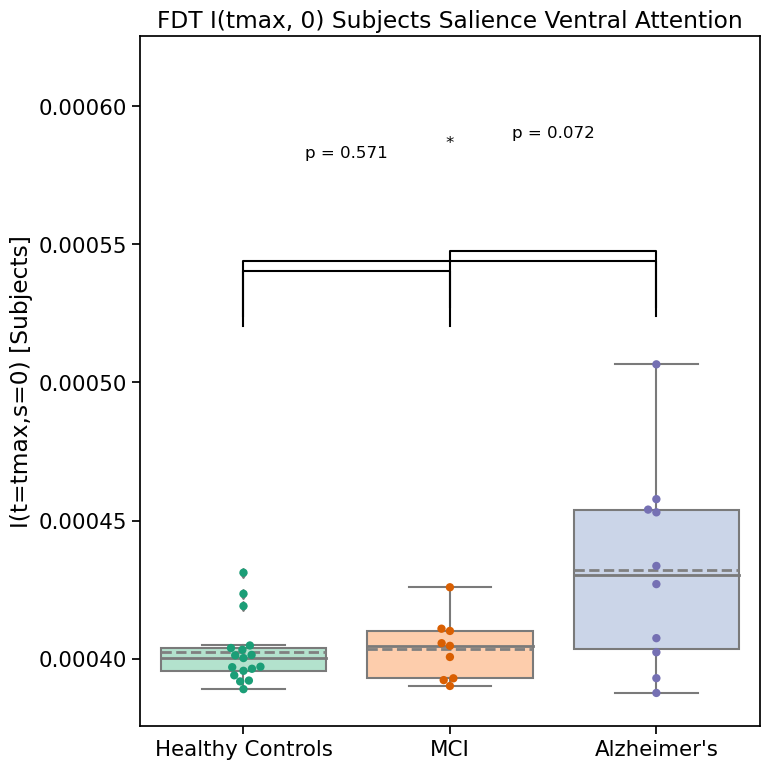

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


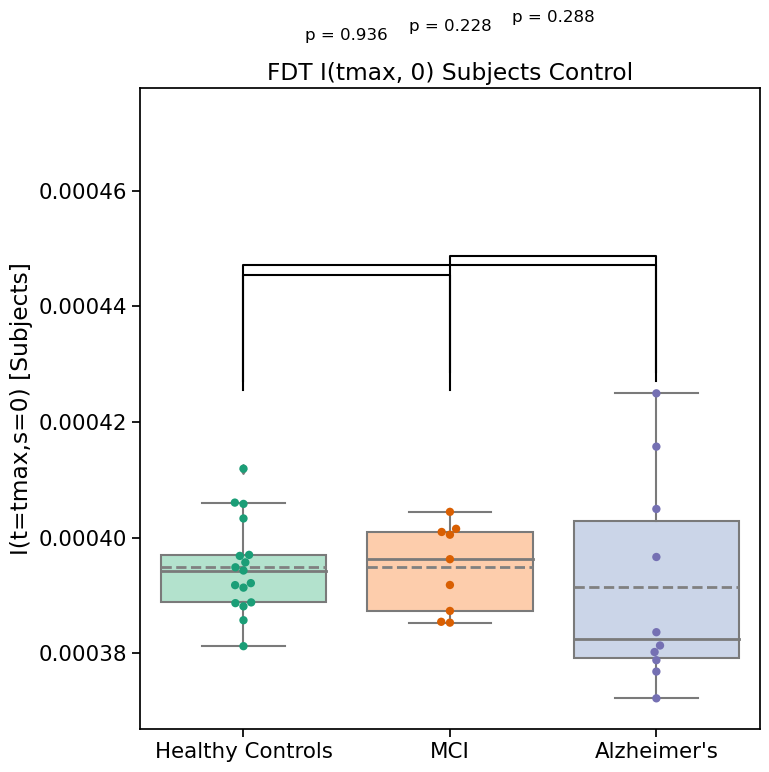

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


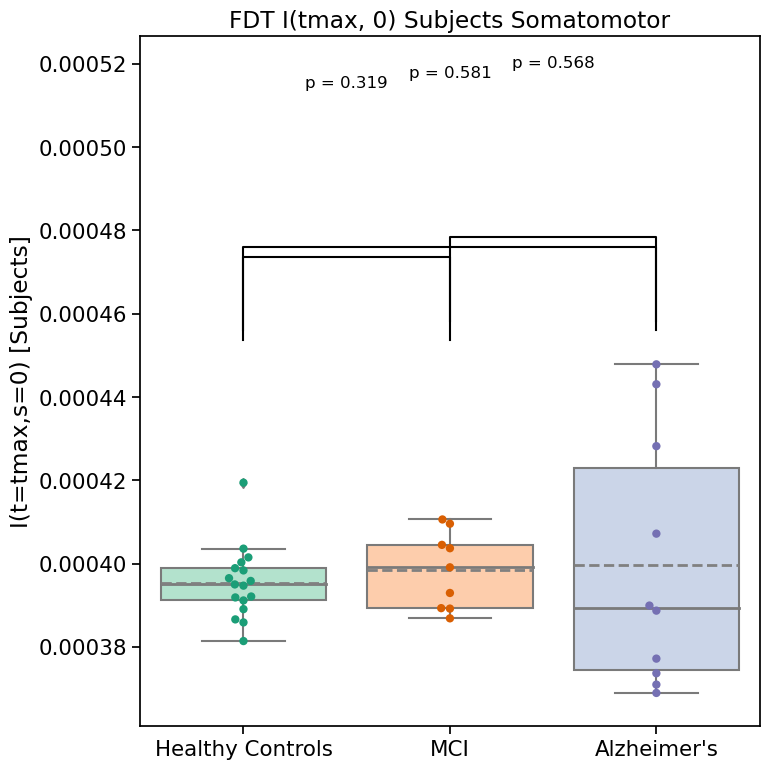

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


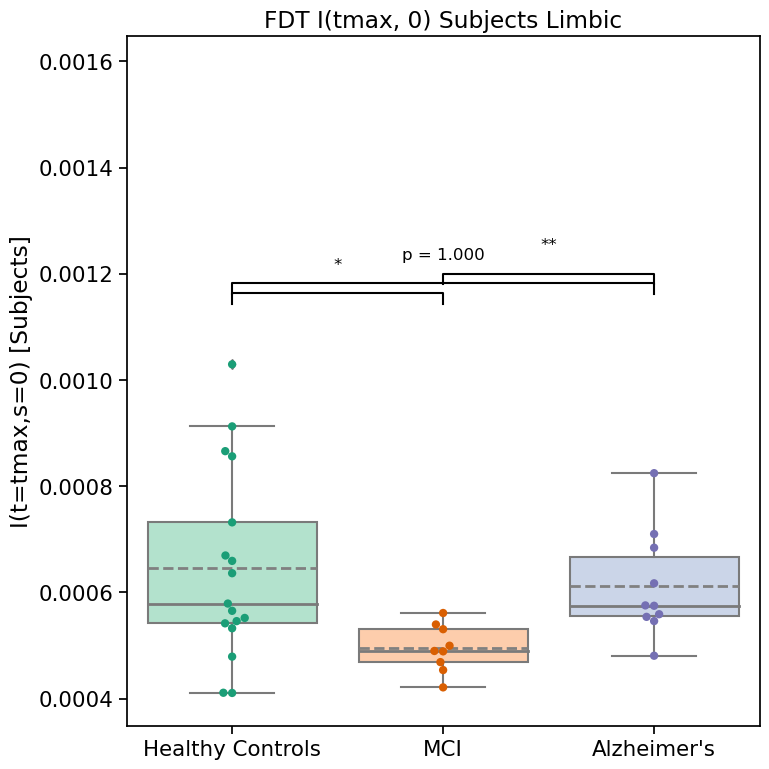

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


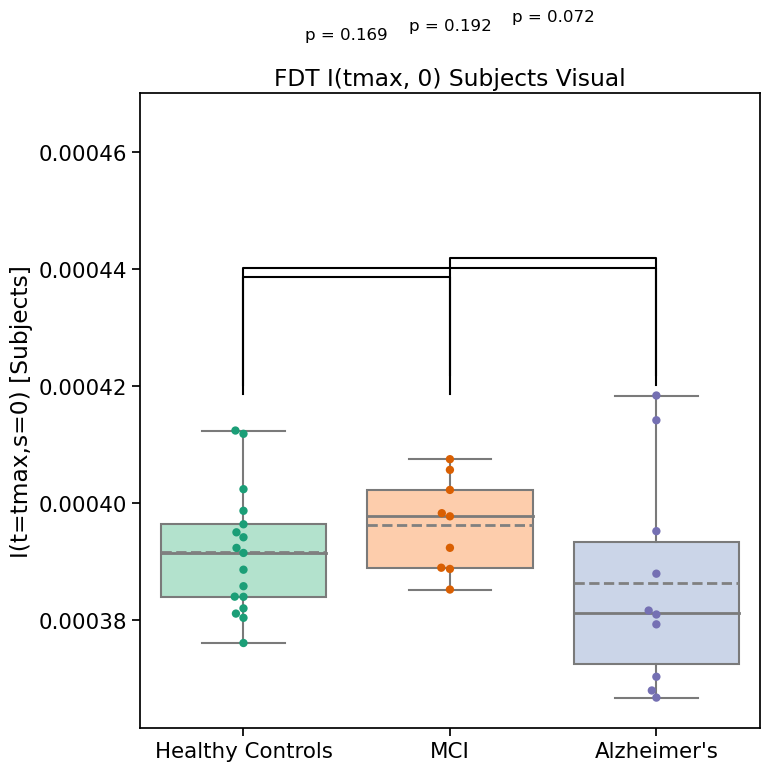

In [26]:
I_HC_def = I_FDT_sub_def[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_def = I_FDT_sub_def[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_def = I_FDT_sub_def[cond_index_map['AD'], :group_sizes['AD']]
data_def = pd.DataFrame({
    "value": np.concatenate([I_HC_def, I_MCI_def, I_AD_def]),
    "cond": ["HC"] * len(I_HC_def) + ["MCI"] * len(I_MCI_def) + ["AD"] * len(I_AD_def)
})
I_HC_dors = I_FDT_sub_dors[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_dors = I_FDT_sub_dors[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_dors = I_FDT_sub_dors[cond_index_map['AD'], :group_sizes['AD']]
data_dors = pd.DataFrame({
    "value": np.concatenate([I_HC_dors, I_MCI_dors, I_AD_dors]),
    "cond": ["HC"] * len(I_HC_dors) + ["MCI"] * len(I_MCI_dors) + ["AD"] * len(I_AD_dors)
})
I_HC_sal = I_FDT_sub_sal[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_sal = I_FDT_sub_sal[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_sal = I_FDT_sub_sal[cond_index_map['AD'], :group_sizes['AD']]
data_sal = pd.DataFrame({
    "value": np.concatenate([I_HC_sal, I_MCI_sal, I_AD_sal]),
    "cond": ["HC"] * len(I_HC_sal) + ["MCI"] * len(I_MCI_sal) + ["AD"] * len(I_AD_sal)
})
I_HC_cont = I_FDT_sub_cont[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_cont = I_FDT_sub_cont[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_cont = I_FDT_sub_cont[cond_index_map['AD'], :group_sizes['AD']]
data_cont = pd.DataFrame({
    "value": np.concatenate([I_HC_cont, I_MCI_cont, I_AD_cont]),
    "cond": ["HC"] * len(I_HC_cont) + ["MCI"] * len(I_MCI_cont) + ["AD"] * len(I_AD_cont)
})
I_HC_som = I_FDT_sub_som[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_som = I_FDT_sub_som[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_som = I_FDT_sub_som[cond_index_map['AD'], :group_sizes['AD']]
data_som = pd.DataFrame({
    "value": np.concatenate([I_HC_som, I_MCI_som, I_AD_som]),
    "cond": ["HC"] * len(I_HC_som) + ["MCI"] * len(I_MCI_som) + ["AD"] * len(I_AD_som)
})
I_HC_limb = I_FDT_sub_limb[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_limb = I_FDT_sub_limb[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_limb = I_FDT_sub_limb[cond_index_map['AD'], :group_sizes['AD']]
data_limb = pd.DataFrame({
    "value": np.concatenate([I_HC_limb, I_MCI_limb, I_AD_limb]),
    "cond": ["HC"] * len(I_HC_limb) + ["MCI"] * len(I_MCI_limb) + ["AD"] * len(I_AD_limb)
})
I_HC_vis = I_FDT_sub_vis[cond_index_map['HC'], :group_sizes['HC']]
I_MCI_vis = I_FDT_sub_vis[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD_vis = I_FDT_sub_vis[cond_index_map['AD'], :group_sizes['AD']]
data_vis = pd.DataFrame({
    "value": np.concatenate([I_HC_vis, I_MCI_vis, I_AD_vis]),
    "cond": ["HC"] * len(I_HC_vis) + ["MCI"] * len(I_MCI_vis) + ["AD"] * len(I_AD_vis)
})

fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(ax=ax, data=data_def,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Subjects]',
            point_size = 6,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Subjects Default',
            saveplot = 1,
            filename=filename,
            dpi=300)
plt.close()
fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(ax=ax, data=data_dors,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Subjects]',
            point_size = 6,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Subjects Dorsal Attention',
            saveplot = 1,
            filename=filename,
            dpi=300)
plt.close()
fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(
    ax=ax, data=data_sal,
    font_scale=1.4, 
    metric='I(t=tmax,s=0) [Subjects]',
    point_size = 6,
    xgrid=False,
    plot_title='FDT I(tmax, 0) Subjects Salience Ventral Attention',
    saveplot = 1,
    filename=filename,
    dpi=300)
plt.close()
fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(
    ax=ax, data=data_cont,
    font_scale=1.4, 
    metric='I(t=tmax,s=0) [Subjects]',
    point_size = 6,
    xgrid=False,
    plot_title='FDT I(tmax, 0) Subjects Control',
    saveplot = 1,
    filename=filename,
    dpi=300)
plt.close()
fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(
    ax=ax, data=data_som,
    font_scale=1.4, 
    metric='I(t=tmax,s=0) [Subjects]',
    point_size = 6,
    xgrid=False,
    plot_title='FDT I(tmax, 0) Subjects Somatomotor',
    saveplot = 1,
    filename=filename,
    dpi=300)
plt.close()
fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(
    ax=ax, data=data_limb,
    font_scale=1.4, 
    metric='I(t=tmax,s=0) [Subjects]',
    point_size = 6,
    xgrid=False,
    plot_title='FDT I(tmax, 0) Subjects Limbic',
    saveplot = 1,
    filename=filename,
    dpi=300)
plt.close()
fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(
    ax=ax, data=data_vis,
    font_scale=1.4, 
    metric='I(t=tmax,s=0) [Subjects]',
    point_size = 6,
    xgrid=False,
    plot_title='FDT I(tmax, 0) Subjects Visual',
    saveplot = 1,
    filename=filename,
    dpi=300)
plt.close()


(3, 36)
(3, 379)
(3, 85)


/Users/mellebolding/MSc/Thesis/ADNI-A/functions_boxplots_WN3_v0.py:141: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(y="value",


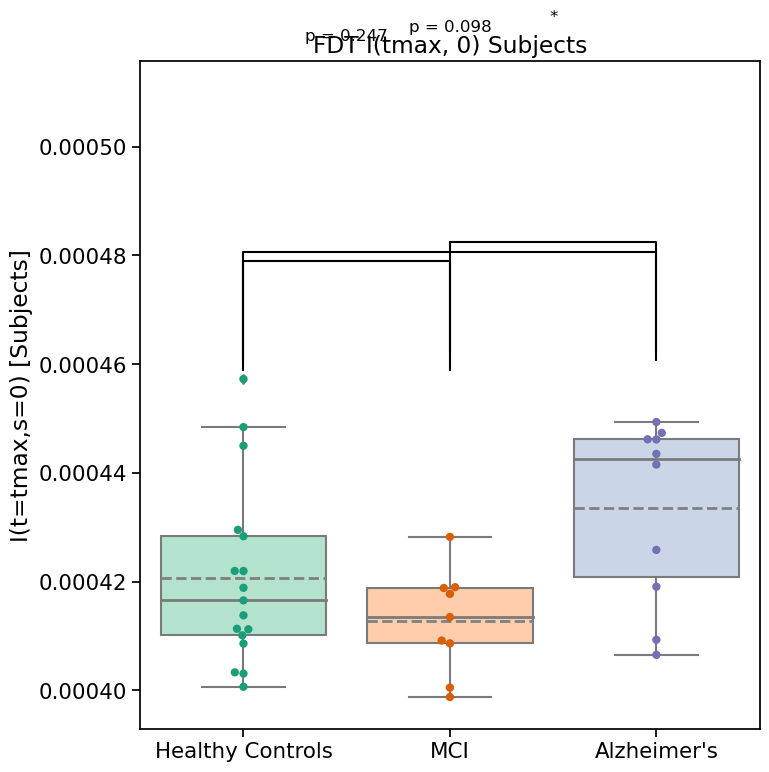

In [ ]:
I_HC = I_FDT_sub[cond_index_map['HC'], :group_sizes['HC']]
I_MCI = I_FDT_sub[cond_index_map['MCI'], :group_sizes['MCI']]
I_AD = I_FDT_sub[cond_index_map['AD'], :group_sizes['AD']]
data = pd.DataFrame({
    "value": np.concatenate([I_HC, I_MCI, I_AD]),
    "cond": ["HC"] * len(I_HC) + ["MCI"] * len(I_MCI) + ["AD"] * len(I_AD)
})

filename = f"FDT_I_Boxplot_sub_COND_{cond}"
import inspect
#print(inspect.getsource(plot_boxes_HC_MCI_AD))

fig, ax = plt.subplots(figsize=(8, 8))
plot_boxes_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4, 
            metric='I(t=tmax,s=0) [Subjects]',
            point_size = 6,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Subjects',
            saveplot = 1,
            filename=filename,
            dpi=300)

/Users/mellebolding/MSc/Thesis/ADNI-A/functions_violinplots_WN3_v0.py:200: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2.0)  # increase padding


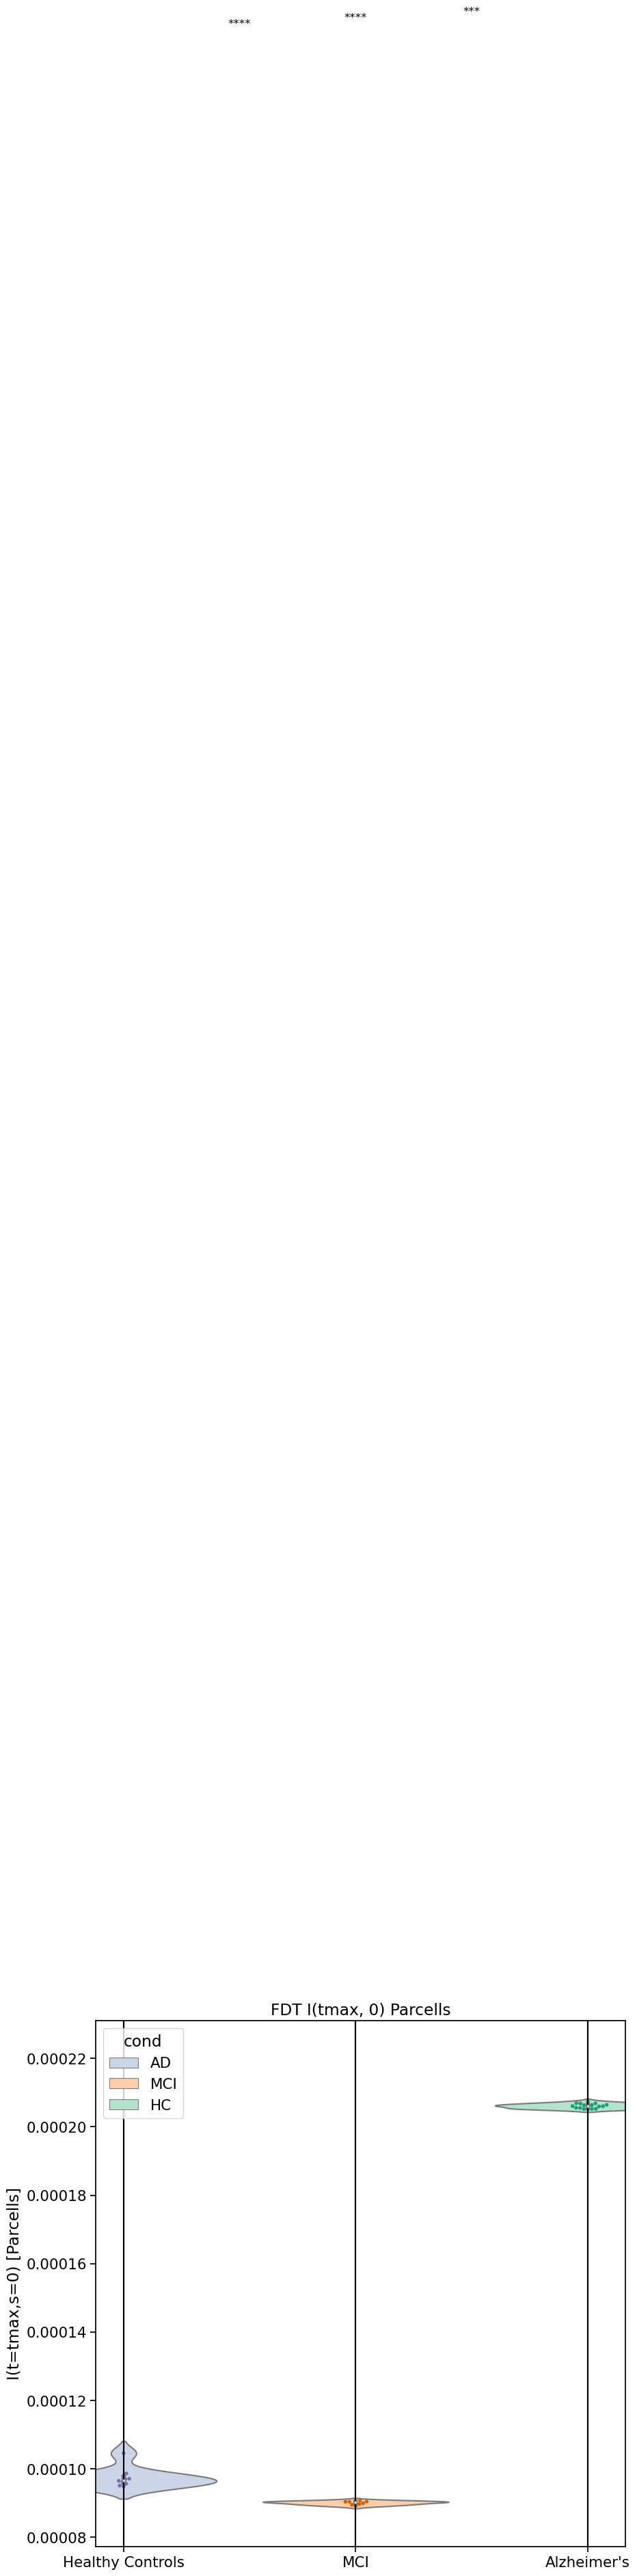

In [ ]:
### Violin-plots for parcells (mean over subjects)
I_HCpar = I_FDT_par[cond_index_map['HC'], :group_sizes['HC']]
I_MCIpar = I_FDT_par[cond_index_map['MCI'], :group_sizes['MCI']]
I_ADpar = I_FDT_par[cond_index_map['AD'], :group_sizes['AD']]
data = pd.DataFrame({
    "value": np.concatenate([I_ADpar, I_MCIpar, I_HCpar]),
    "cond": ["AD"] * len(I_ADpar) + ["MCI"] * len(I_MCIpar) + ["HC"] * len(I_HCpar)
})

filename = f"FDT_I_Violinplot_par_COND_{COND}"

fig, ax = plt.subplots(figsize=(10, 10))
plot_violins_HC_MCI_AD(ax=ax, data=data,
            font_scale=1.4,
            metric='I(t=tmax,s=0) [Parcells]',
            point_size = 4,
            xgrid=False,
            plot_title='FDT I(tmax, 0) Parcells',
            saveplot = 1,
            filename=filename,
            dpi=300)

---

# TO DO:
- save FDT plots with coresponding filenames